Recognising multiple images with YOLO darknet


Mapping Google drive to /content/drive

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

Mounted at /content/drive
Note: using Google CoLab


Installing YoloV3-TF2

In [2]:
import sys

!{sys.executable} -m pip install \
  git+https://github.com/zzh8829/yolov3-tf2.git@master

  Cloning https://github.com/zzh8829/yolov3-tf2.git (to revision master) to /tmp/pip-req-build-j11b2uks
  Running command git clone -q https://github.com/zzh8829/yolov3-tf2.git /tmp/pip-req-build-j11b2uks
  Created wheel for yolov3-tf2: filename=yolov3_tf2-0.1-cp37-none-any.whl size=9139 sha256=fe54b640bbf1f4d974832e5afc2e16114c8f251449a590e7432d968dda2ea4ce
  Stored in directory: /tmp/pip-ephem-wheel-cache-lox46xkq/wheels/59/1b/97/905ab51e9c0330efe8c3c518aff17de4ee91100412cd6dd553
Successfully built yolov3-tf2


Downloading various essential files for training:

**yolov3.weights** - These are the pre-trained weights provided by the author of YOLO.

**convert.py** - This is a Python script that converts yolov3.weights into a TensorFlow compatible weight format.

**coco.names** - The names of the 80 items that the yolov3.weights neural network was trained to recognize.

**yolov3.tf** - The YOLO weights converted to a format that TensorFlow can use directly.

In [3]:
import tensorflow as tf
import os

if COLAB:
  ROOT = '/content/drive/My Drive/projects/t81_558_dlearning/yolo'
else:
  ROOT = os.path.join(os.getcwd(),'data')

filename_darknet_weights = tf.keras.utils.get_file(
    os.path.join(ROOT,'yolov3.weights'),
    origin='https://pjreddie.com/media/files/yolov3.weights')
TINY = False

filename_convert_script = tf.keras.utils.get_file(
    os.path.join(os.getcwd(),'convert.py'),
    origin="https://raw.githubusercontent.com/zzh8829/"\
      "yolov3-tf2/master/convert.py")

filename_classes = tf.keras.utils.get_file(
    os.path.join(ROOT,'coco.names'),
    origin="https://raw.githubusercontent.com/zzh8829/"\
      "yolov3-tf2/master/data/coco.names")
filename_converted_weights = os.path.join(ROOT,'yolov3.tf')

8192/1277 [================================================================================================================================================================================================] - 0s 0us/step


Converting the original YOLO weights into a version that is compabtible with tensor flow

In [4]:
import sys
!{sys.executable} "{filename_convert_script}" --weights \
    "{filename_darknet_weights}" --output "{filename_converted_weights}"

2021-07-16 09:53:53.875862: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-16 09:53:56.285891: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-16 09:53:56.341199: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-07-16 09:53:56.341268: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (feafa6df0642): /proc/driver/nvidia/version does not exist
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
W0716 09:53:59.208571 140686073517952 deprecation.py:534] From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/array_ops.py:5049: calling gather (from tensorflow.python.ops.array_ops) with validate

The conversion script is no longer needed once this script converts the YOLO weights have to a TensorFlow format. Therefore, we shall delete it.

In [5]:
import os
os.remove(filename_convert_script)

In [6]:
import time
from absl import app, flags, logging
from absl.flags import FLAGS
import cv2
import numpy as np
import tensorflow as tf
from yolov3_tf2.models import (YoloV3, YoloV3Tiny)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs
import sys
from PIL import Image, ImageFile
import requests

# Flags are used to define several options for YOLO.
flags.DEFINE_string('classes', filename_classes, 'path to classes file')
flags.DEFINE_string('weights', filename_converted_weights, \
                    'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')
FLAGS([sys.argv[0]])

# Locate devices to run YOLO on (e.g. GPU)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [7]:
# This example does not use the "Tiny version"
if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)

# Load weights and classes
yolo.load_weights(FLAGS.weights).expect_partial()
print('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
print('classes loaded')

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
weights loaded
classes loaded


In [12]:
class_names

['person',
 'bicycle',
 'car',
 'motorbike',
 'aeroplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'sofa',
 'pottedplant',
 'bed',
 'diningtable',
 'toilet',
 'tvmonitor',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

Next, we obtain an image to classify. The program loads the image from a URL. YoloV3-TF2 expects that the image is in the format of a Numpy array. An image file, such as JPEG or PNG, is converted into this raw Numpy format by calling the TensorFlow decode_image function. YoloV3-TF2 can obtain images from other sources, so long as the program first decodes them to raw Numpy format. The following code obtains the image in this format.

In [24]:
# Read image to classify
url = "https://i.pinimg.com/originals/2e/dd/34/2edd34f06447226682bacea70fb8aec4.jpg"
response = requests.get(url)
img_raw = tf.image.decode_image(response.content, channels=3)

In [25]:
img_raw.shape
img = tf.expand_dims(img_raw, 0)
img

<tf.Tensor: shape=(1, 1898, 735, 3), dtype=uint8, numpy=
array([[[[199, 177, 156],
         [197, 175, 154],
         [197, 175, 154],
         ...,
         [221, 206, 177],
         [221, 206, 177],
         [220, 205, 176]],

        [[191, 169, 148],
         [190, 168, 147],
         [192, 170, 149],
         ...,
         [211, 196, 167],
         [210, 195, 166],
         [208, 193, 164]],

        [[183, 162, 141],
         [181, 160, 139],
         [181, 160, 139],
         ...,
         [215, 198, 172],
         [216, 199, 173],
         [217, 200, 174]],

        ...,

        [[254, 254, 254],
         [254, 254, 254],
         [254, 254, 254],
         ...,
         [254, 254, 254],
         [254, 254, 254],
         [254, 254, 254]],

        [[254, 254, 254],
         [254, 254, 254],
         [254, 254, 254],
         ...,
         [254, 254, 254],
         [254, 254, 254],
         [254, 254, 254]],

        [[254, 254, 254],
         [254, 254, 254],
         [254, 25

In [26]:
# Preprocess image
img = tf.expand_dims(img_raw, 0)   # expanding from 3d to 4d vector along the zeroth dimension
img = transform_images(img, FLAGS.size)

# Desired threshold (any sub-image below this confidence 
# level will be ignored.)
FLAGS.yolo_score_threshold = 0.5

# Recognize and report results
t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
print(f"Prediction time: {hms_string(t2 - t1)}")

Prediction time: 0:00:01.46


In [27]:
print('detections:')
for i in range(nums[0]):
    cls = class_names[int(classes[0][i])]
    score = np.array(scores[0][i])
    box = np.array(boxes[0][i])
    print(f"\t{cls}, {score}, {box}")

detections:
	scissors, 0.6775161027908325, [0.38349536 0.5283919  0.9352186  0.7259428 ]


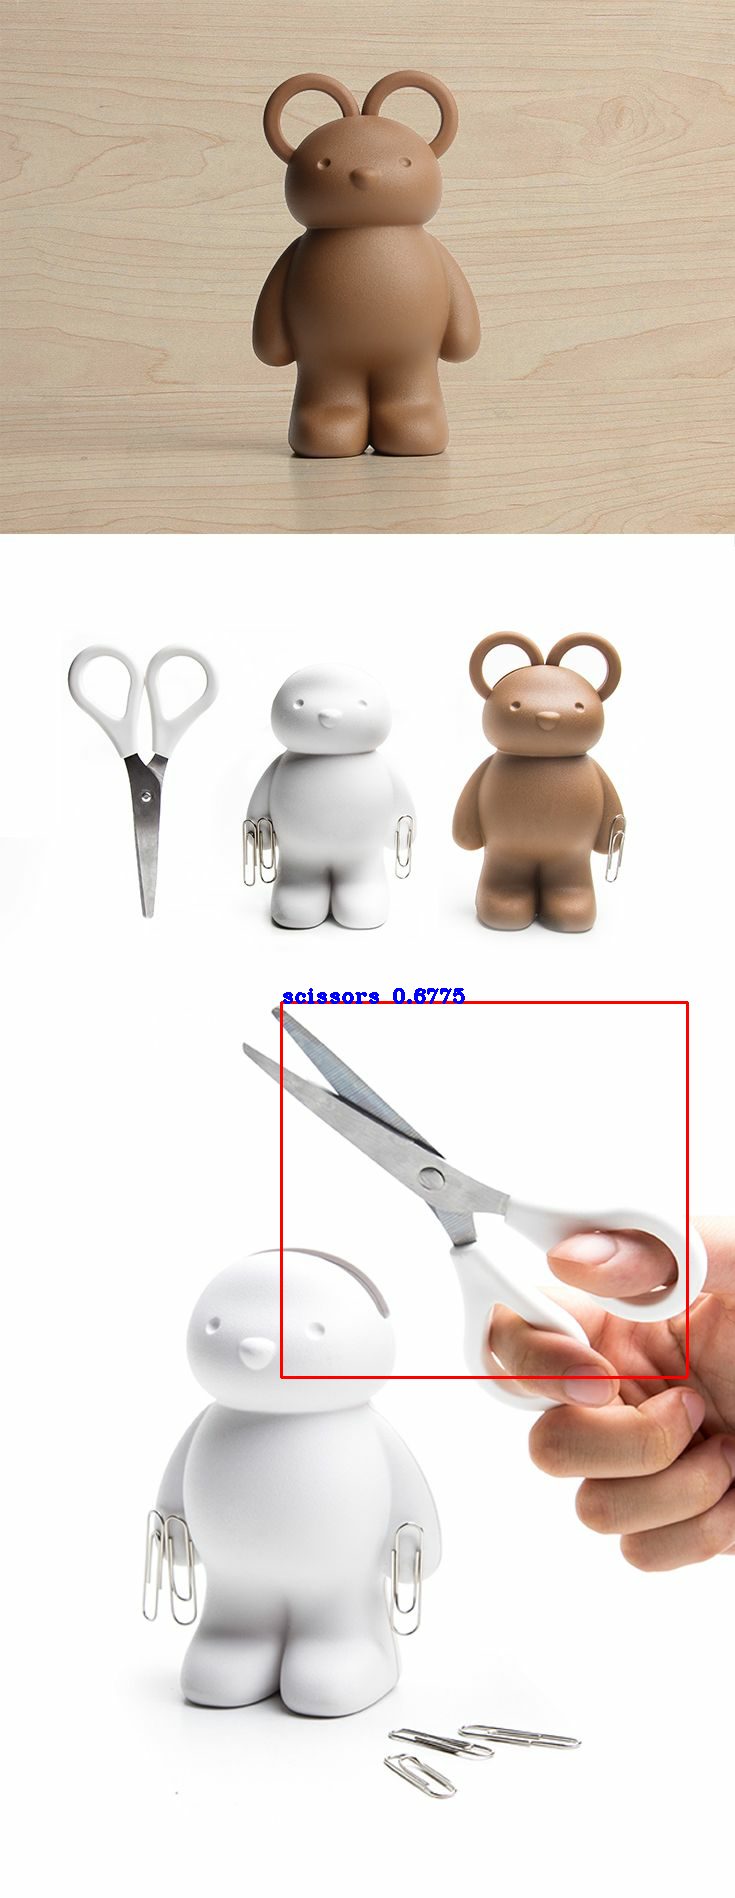

In [28]:
# Display image using YOLO library's built in function
img = img_raw.numpy()
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
#cv2.imwrite(FLAGS.output, img) # Save the image
display(Image.fromarray(img, 'RGB')) # Display the image